In [1]:
# !pip install stellargraph

In [2]:
!pip install stellargraph[demos]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 7.9 MB/s 
     |████████████████████████████████| 500 kB 42.9 MB/s 
     |████████████████████████████████| 120 kB 53.7 MB/s 
     |████████████████████████████████| 1.6 MB 45.3 MB/s 
     |████████████████████████████████| 82 kB 430 kB/s 
     |████████████████████████████████| 41 kB 404 kB/s 
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28582 sha256=4638e18ecd07ea1140e52b320aa0b5abb0f0b06623c6e8aea24f684b9e6d91ab
  Stored in directory: /root/.cache/pip/wheels/6b/f5/21/cdd12e476182b4b0b98326cdb9efa02ddbd5d87ca5de051c84
Successfully built mplleaflet


# Data preparation

In [3]:
import pandas as pd
from sklearn import model_selection

def load_my_data():
    # your own code to load data into Pandas DataFrames, e.g. from CSV files or a database
    ...

nodes, edges, targets = load_my_data()

# Use scikit-learn to compute training and test sets
train_targets, test_targets = model_selection.train_test_split(targets, train_size=0.5)

# Graph Machine Learning Model

In [4]:
import stellargraph as sg
import tensorflow as tf

# convert the raw data into StellarGraph's graph format for faster operations
graph = sg.StellarGraph(nodes, edges)

generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")

# two layers of GCN, each with hidden dimension 16
gcn = sg.layer.GCN(layer_sizes=[16, 16], generator=generator)
x_inp, x_out = gcn.in_out_tensors() # create the input and output TensorFlow tensors

# use TensorFlow Keras to add a layer to compute the (one-hot) predictions
predictions = tf.keras.layers.Dense(units=len(ground_truth_targets.columns), activation="softmax")(x_out)

# use the input and output tensors to create a TensorFlow Keras model
model = tf.keras.Model(inputs=x_inp, outputs=predictions)

# Training and evaluation

In [5]:
# # prepare the model for training with the Adam optimiser and an appropriate loss function
# model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # train the model on the train set
# model.fit(generator.flow(train_targets.index, train_targets), epochs=5)

# # check model generalisation on the test set
# (loss, accuracy) = model.evaluate(generator.flow(test_targets.index, test_targets))
# print(f"Test set: loss = {loss}, accuracy = {accuracy}")

# Node classification with Graph Convolutional Network (GCN)

In [6]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data preparation

### Loading the CORA network

In [7]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [8]:
dataset

In [9]:
print(G)
# print(node_subjects)

In [10]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [11]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Splitting the data

In [12]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [13]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


### Converting to numeric arrays

In [14]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## 2. Creating the GCN layers

In [15]:
generator = FullBatchNodeGenerator(G, method="gcn")
generator

Using GCN (local pooling) filters...


In [16]:
train_gen = generator.flow(train_subjects.index, train_targets)
train_gen 

In [17]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [18]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [19]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions

<KerasTensor: shape=(1, None, 7) dtype=float32 (created by layer 'dense')>

## 3. Training and evaluating

### Training the model

In [20]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [23]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9356 - acc: 0.2000 - val_loss: 1.8809 - val_acc: 0.3000 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.8689 - acc: 0.3214 - val_loss: 1.8246 - val_acc: 0.3060 - 173ms/epoch - 173ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8019 - acc: 0.3357 - val_loss: 1.7621 - val_acc: 0.3240 - 172ms/epoch - 172ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7174 - acc: 0.3286 - val_loss: 1.6949 - val_acc: 0.3440 - 169ms/epoch - 169ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6254 - acc: 0.4000 - val_loss: 1.6251 - val_acc: 0.3660 - 252ms/epoch - 252ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5341 - acc: 0.4214 - val_loss: 1.5558 - val_acc: 0.3840 - 233ms/epoch - 233ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4619 - acc: 0.4429 - val_loss: 1.4843 - val_acc: 0.4100 - 166ms/epoch - 166ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3383 - acc: 0.4857 - val_loss: 1.4123 - val_acc: 0.4580 - 169ms/epoch - 169ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2651 - acc: 0.5000 - val_loss: 1.3422 - val_acc: 0.4940 - 168ms

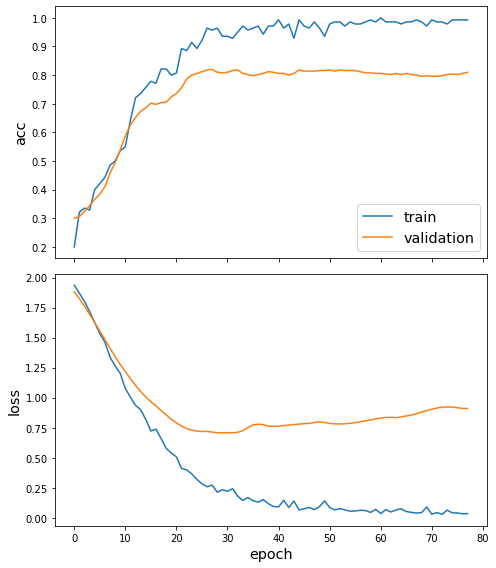

In [24]:
sg.utils.plot_history(history)

In [25]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [26]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 185ms/step - loss: 0.8324 - acc: 0.7761

Test Set Metrics:
	loss: 0.8324
	acc: 0.7761


### Making predictions with the model

In [27]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [28]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [29]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Neural_Networks,Theory
1102850,Probabilistic_Methods,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


### Node embeddings

In [30]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [31]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [33]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [34]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

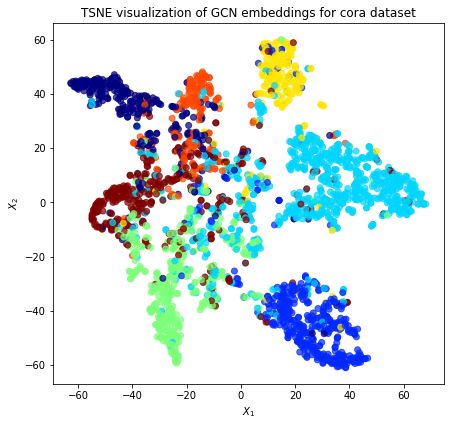

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

# Node classification with GraphSAGE

## Creating the GraphSAGE model in Keras

In [36]:
batch_size = 50
num_samples = [10, 5]

In [37]:
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

import networkx as nx

generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [38]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [39]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [40]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

In [41]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [43]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
3/3 - 4s - loss: 1.9115 - acc: 0.2071 - val_loss: 1.7921 - val_acc: 0.3694 - 4s/epoch - 1s/step
Epoch 2/20
3/3 - 2s - loss: 1.7174 - acc: 0.5000 - val_loss: 1.6990 - val_acc: 0.3926 - 2s/epoch - 658ms/step
Epoch 3/20
3/3 - 3s - loss: 1.5947 - acc: 0.5500 - val_loss: 1.6233 - val_acc: 0.4560 - 3s/epoch - 947ms/step
Epoch 4/20
3/3 - 2s - loss: 1.5092 - acc: 0.6429 - val_loss: 1.5536 - val_acc: 0.5247 - 2s/epoch - 688ms/step
Epoch 5/20
3/3 - 3s - loss: 1.3938 - acc: 0.8000 - val_loss: 1.4766 - val_acc: 0.6011 - 3s/epoch - 946ms/step
Epoch 6/20
3/3 - 3s - loss: 1.3057 - acc: 0.8500 - val_loss: 1.4114 - val_acc: 0.6528 - 3s/epoch - 951ms/step
Epoch 7/20
3/3 - 2s - loss: 1.2289 - acc: 0.8786 - val_loss: 1.3584 - val_acc: 0.6741 - 2s/epoch - 791ms/step
Epoch 8/20
3/3 - 3s - loss: 1.1522 - acc: 0.9143 - val_loss: 1.2975 - val_acc: 0.7036 - 3s/epoch - 1s/step
Epoch 9/20
3/3 - 3s - loss: 1.0834 - acc: 0.9071 - val_loss: 1.2504 - val_acc: 0.7162 - 3s/epoch - 945ms/step
Epoch 10/20
3/3 

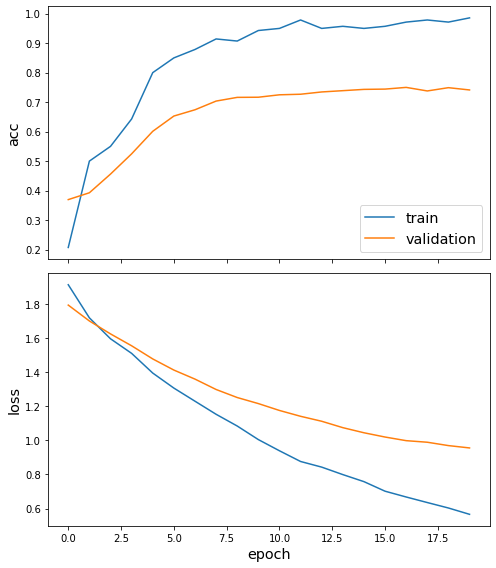

In [44]:
sg.utils.plot_history(history)

In [45]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

42/42 [==============================] - 2s 47ms/step - loss: 0.9519 - acc: 0.7495

Test Set Metrics:
	loss: 0.9519
	acc: 0.7495


### Making predictions with the model

In [46]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [47]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [48]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Probabilistic_Methods,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


In [49]:
Gnx = G.to_networkx(feature_attr=None)

In [50]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

In [51]:
for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

In [52]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

In [53]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

### Node embeddings

In [54]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_mapper)
emb.shape

(2708, 32)

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [56]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [57]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


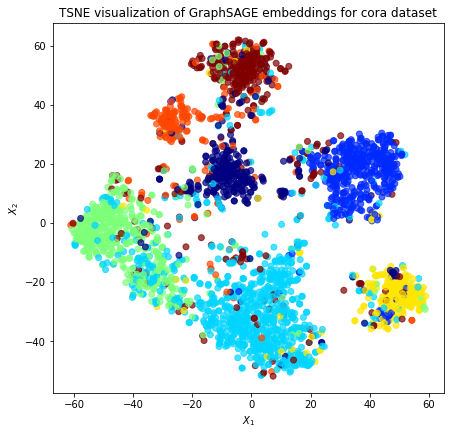

In [58]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

# Node classification with Graph ATtention Network (GAT)



## Creating the GraphSAGE model in Keras

In [59]:
batch_size = 50
num_samples = [10, 5]

In [60]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [61]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [62]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [63]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

## Training the model

In [64]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [66]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
3/3 - 4s - loss: 1.9344 - acc: 0.2000 - val_loss: 1.7805 - val_acc: 0.3225 - 4s/epoch - 1s/step
Epoch 2/20
3/3 - 2s - loss: 1.7316 - acc: 0.4286 - val_loss: 1.7172 - val_acc: 0.3075 - 2s/epoch - 737ms/step
Epoch 3/20
3/3 - 3s - loss: 1.6148 - acc: 0.4714 - val_loss: 1.6478 - val_acc: 0.3448 - 3s/epoch - 947ms/step
Epoch 4/20
3/3 - 3s - loss: 1.5196 - acc: 0.5929 - val_loss: 1.5743 - val_acc: 0.4652 - 3s/epoch - 957ms/step
Epoch 5/20
3/3 - 2s - loss: 1.4490 - acc: 0.6643 - val_loss: 1.5049 - val_acc: 0.5788 - 2s/epoch - 718ms/step
Epoch 6/20
3/3 - 3s - loss: 1.3445 - acc: 0.7929 - val_loss: 1.4337 - val_acc: 0.6451 - 3s/epoch - 944ms/step
Epoch 7/20
3/3 - 3s - loss: 1.2664 - acc: 0.8429 - val_loss: 1.3696 - val_acc: 0.6654 - 3s/epoch - 943ms/step
Epoch 8/20
3/3 - 2s - loss: 1.1840 - acc: 0.8857 - val_loss: 1.3072 - val_acc: 0.6799 - 2s/epoch - 712ms/step
Epoch 9/20
3/3 - 2s - loss: 1.1138 - acc: 0.9143 - val_loss: 1.2516 - val_acc: 0.6992 - 2s/epoch - 686ms/step
Epoch 10/20
3

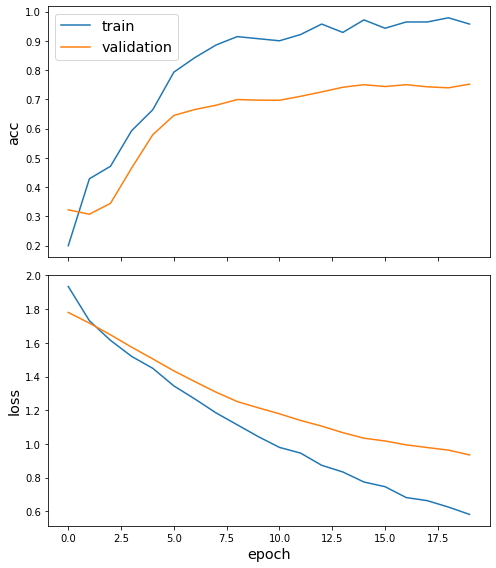

In [67]:
sg.utils.plot_history(history)

In [68]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

42/42 [==============================] - 2s 50ms/step - loss: 0.9370 - acc: 0.7548

Test Set Metrics:
	loss: 0.9370
	acc: 0.7548


## Making predictions with the model

In [69]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [70]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [71]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Neural_Networks,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Probabilistic_Methods,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


In [72]:
Gnx = G.to_networkx(feature_attr=None)

In [73]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

In [74]:
for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

In [75]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

In [76]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

## Node embeddings

In [77]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_mapper)
emb.shape

(2708, 32)

In [78]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [79]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [80]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


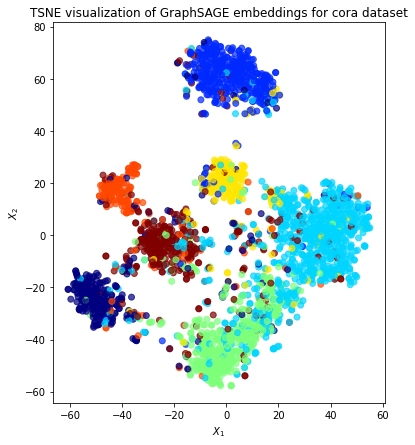

In [81]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

# Supervised graph classification with GCN

In [82]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

## Import the data

In [83]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [84]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 17, Edges: 38

 Node types:
  default: [17]
    Features: float32 vector, length 7
    Edge types: default-default->default

 Edge types:
    default-default->default: [38]
        Weights: all 1 (default)
        Features: none


In [85]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 13, Edges: 28

 Node types:
  default: [13]
    Features: float32 vector, length 7
    Edge types: default-default->default

 Edge types:
    default-default->default: [28]
        Weights: all 1 (default)
        Features: none


In [86]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,188.0,188.0
mean,17.9,39.6
std,4.6,11.4
min,10.0,20.0
25%,14.0,28.0
50%,17.5,38.0
75%,22.0,50.0
max,28.0,66.0


In [87]:
graph_labels.value_counts().to_frame()

,label
1,125
-1,63


In [88]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

## Prepare graph generator

In [89]:
generator = PaddedGraphGenerator(graphs=graphs)

## Create the Keras graph classification model

![gcn](https://stellargraph.readthedocs.io/en/stable/_images/graph_classification_architecture.png)

In [90]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

## Train the model

In [91]:
epochs = 200  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [92]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [93]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [94]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [95]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 50...
Training and evaluating on fold 2 out of 50...
Training and evaluating on fold 3 out of 50...
Training and evaluating on fold 4 out of 50...
Training and evaluating on fold 5 out of 50...
Training and evaluating on fold 6 out of 50...
Training and evaluating on fold 7 out of 50...
Training and evaluating on fold 8 out of 50...
Training and evaluating on fold 9 out of 50...
Training and evaluating on fold 10 out of 50...
Training and evaluating on fold 11 out of 50...
Training and evaluating on fold 12 out of 50...
Training and evaluating on fold 13 out of 50...
Training and evaluating on fold 14 out of 50...
Training and evaluating on fold 15 out of 50...
Training and evaluating on fold 16 out of 50...
Training and evaluating on fold 17 out of 50...
Training and evaluating on fold 18 out of 50...
Training and evaluating on fold 19 out of 50...
Training and evaluating on fold 20 out of 50...
Training and evaluating on fold 21 out of 50...
T

In [96]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 75.8% and std: 6.6%


Text(0, 0.5, 'Count')

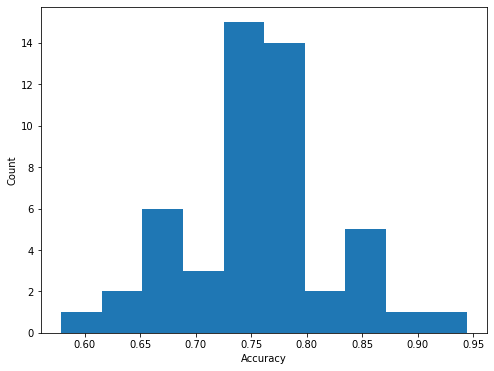

In [97]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [98]:
print(generator)

In [99]:
print(graphs)

[<stellargraph.core.graph.StellarGraph object at 0x7f3d9314aa10>, <stellargraph.core.graph.StellarGraph object at 0x7f3d9334b7d0>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922c5790>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922c5d50>, <stellargraph.core.graph.StellarGraph object at 0x7f3d9334b8d0>, <stellargraph.core.graph.StellarGraph object at 0x7f3d9314ae90>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922c5410>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922d5e50>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922d5490>, <stellargraph.core.graph.StellarGraph object at 0x7f3d922d5a50>, <stellargraph.core.graph.StellarGraph object at 0x7f3d9317aad0>, <stellargraph.core.graph.StellarGraph object at 0x7f3d931a7c10>, <stellargraph.core.graph.StellarGraph object at 0x7f3d93158cd0>, <stellargraph.core.graph.StellarGraph object at 0x7f3d93158e10>, <stellargraph.core.graph.StellarGraph object at 0x7f3d93341450>, <stellargraph.core.graph